In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')


data_dir = Path('../Data/Processed')
X = pd.read_csv(data_dir / 'X_aggregated.csv')
y = pd.read_csv(data_dir / 'y_labels.csv').values.ravel()

print(f"Total features: {X.shape[1]}")
print(f"Total samples: {X.shape[0]}")

Total features: 165
Total samples: 100


In [2]:
online_sensors = [
    'Aeration rate(Fg:L/h)',
    'Agitator RPM(RPM:RPM)', 
    'Sugar feed rate(Fs:L/h)',
    'Acid flow rate(Fa:L/h)',
    'Base flow rate(Fb:L/h)',
    'Heating/cooling water flow rate(Fc:L/h)',
    'Heating water flow rate(Fh:L/h)',
    'Water for injection/dilution(Fw:L/h)',
    'Air head pressure(pressure:bar)',
    'Dissolved oxygen concentration(DO2:mg/L)',
    'pH(pH:pH)',
    'Temperature(T:K)',
    'carbon dioxide percent in off-gas(CO2outgas:%)',
    'Oxygen in percent in off-gas(O2:O2  (%))',
    'Vessel Volume(V:L)',
    'Vessel Weight(Wt:Kg)',
    'Generated heat(Q:kJ)',
    'Carbon evolution rate(CER:g/h)',
    'Oxygen Uptake Rate(OUR:(g min^{-1}))'
]


offline_sensors = [
    'Penicillin concentration(P:g/L)', 
    'PAA flow(Fpaa:PAA flow (L/h))',
    'PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
    'Oil flow(Foil:L/hr)',
    'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
    'Offline Penicillin concentration(P_offline:P(g L^{-1}))',
    'Offline Biomass concentratio(X_offline:X(g L^{-1}))',
    'Ammonia shots(NH3_shots:kgs)',
    'Viscosity(Viscosity_offline:centPoise)'
]

In [3]:

online_feature_cols = []
for col in X.columns:
    
    if any(col.startswith(sensor) for sensor in online_sensors):
        online_feature_cols.append(col)

print(f"\nOnline sensor features: {len(online_feature_cols)}")

# filtered dataset
X_online = X[online_feature_cols].copy()

print(f"\nFiltered dataset shape: {X_online.shape}")

# Train-Val-Test split (70/15/15)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_online, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"\nData split:")
print(f"Train: {X_train.shape[0]} samples")
print(f"Val: {X_val.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")



Online sensor features: 95

Filtered dataset shape: (100, 95)

Data split:
Train: 70 samples
Val: 15 samples
Test: 15 samples


In [4]:

train_df = pd.concat([X_train.reset_index(drop=True), 
                      pd.Series(y_train, name='fault')], axis=1)

maj_class = 0 
min_class = 1  

maj_df = train_df[train_df['fault'] == maj_class]
min_df = train_df[train_df['fault'] == min_class]

min_upsampled = resample(
    min_df,
    replace=True,
    n_samples=len(maj_df),
    random_state=42
)

train_balanced = pd.concat([maj_df, min_upsampled]).sample(frac=1, random_state=42)


X_train = train_balanced.drop('fault', axis=1)
y_train = train_balanced['fault'].values

print(f"\nAfter balancing:")
print(f"Train: {X_train.shape[0]} samples, Fault dist: {np.bincount(y_train)}")
print(f"Val:   {X_val.shape[0]} samples, Fault dist: {np.bincount(y_val)} (unchanged)")
print(f"Test:  {X_test.shape[0]} samples, Fault dist: {np.bincount(y_test)} (unchanged)")


After balancing:
Train: 126 samples, Fault dist: [63 63]
Val:   15 samples, Fault dist: [13  2] (unchanged)
Test:  15 samples, Fault dist: [14  1] (unchanged)


In [5]:

xgb_online = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    scale_pos_weight=9,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_online.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

[0]	validation_0-logloss:0.78038	validation_1-logloss:1.28236
[1]	validation_0-logloss:0.65382	validation_1-logloss:1.10963
[2]	validation_0-logloss:0.56882	validation_1-logloss:0.98770
[3]	validation_0-logloss:0.49644	validation_1-logloss:0.90129
[4]	validation_0-logloss:0.43971	validation_1-logloss:0.83089
[5]	validation_0-logloss:0.39131	validation_1-logloss:0.77220
[6]	validation_0-logloss:0.35551	validation_1-logloss:0.72769
[7]	validation_0-logloss:0.32096	validation_1-logloss:0.68896
[8]	validation_0-logloss:0.29099	validation_1-logloss:0.65186
[9]	validation_0-logloss:0.26520	validation_1-logloss:0.62596
[10]	validation_0-logloss:0.24256	validation_1-logloss:0.60257
[11]	validation_0-logloss:0.22328	validation_1-logloss:0.58411
[12]	validation_0-logloss:0.20606	validation_1-logloss:0.57766
[13]	validation_0-logloss:0.19127	validation_1-logloss:0.56687
[14]	validation_0-logloss:0.17794	validation_1-logloss:0.55638
[15]	validation_0-logloss:0.16652	validation_1-logloss:0.55733
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

In [6]:

y_train_pred = xgb_online.predict(X_train)
y_val_pred = xgb_online.predict(X_val)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
train_f1 = f1_score(y_train, y_train_pred)
val_f1 = f1_score(y_val, y_val_pred)


print(f"Train - Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}")
print(f"Val   - Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}")


Train - Accuracy: 1.0000, F1: 1.0000
Val   - Accuracy: 0.8000, F1: 0.4000


In [7]:
# %% Feature importance for online sensors
feature_importance_online = pd.DataFrame({
    'feature': X_online.columns,
    'importance': xgb_online.feature_importances_
}).sort_values('importance', ascending=False)

print("TOP 15 MOST IMPORTANT ONLINE SENSORS")
print(feature_importance_online.head(15).to_string(index=False))

TOP 15 MOST IMPORTANT ONLINE SENSORS
                                     feature  importance
                  Acid flow rate(Fa:L/h)_max    0.301827
                  Acid flow rate(Fa:L/h)_std    0.141718
          Carbon evolution rate(CER:g/h)_std    0.084098
   Oxygen Uptake Rate(OUR:(g min^{-1}))_mean    0.072618
Dissolved oxygen concentration(DO2:mg/L)_std    0.063487
    Oxygen Uptake Rate(OUR:(g min^{-1}))_max    0.027357
                 Acid flow rate(Fa:L/h)_mean    0.025672
        Heating water flow rate(Fh:L/h)_mean    0.022676
         Heating water flow rate(Fh:L/h)_std    0.019773
       Heating water flow rate(Fh:L/h)_trend    0.019647
                               pH(pH:pH)_std    0.019261
                  Generated heat(Q:kJ)_trend    0.017068
                   Aeration rate(Fg:L/h)_std    0.016595
                       Temperature(T:K)_mean    0.015606
                 Base flow rate(Fb:L/h)_mean    0.014776


Aggregating the features to get correct ranking

In [8]:

sensor_importance = {}
for idx, row in feature_importance_online.iterrows():
   
    feature_name = row['feature']
 
    for sensor in online_sensors:
        if feature_name.startswith(sensor):
            if sensor not in sensor_importance:
                sensor_importance[sensor] = 0
            sensor_importance[sensor] += row['importance']
            break

# Sort by total importance
sensor_importance_df = pd.DataFrame(
    list(sensor_importance.items()),
    columns=['Sensor', 'Total_Importance']
).sort_values('Total_Importance', ascending=False)


print(sensor_importance_df.to_string(index=False))

                                        Sensor  Total_Importance
                        Acid flow rate(Fa:L/h)          0.469216
          Oxygen Uptake Rate(OUR:(g min^{-1}))          0.102933
                Carbon evolution rate(CER:g/h)          0.084098
      Dissolved oxygen concentration(DO2:mg/L)          0.070375
               Heating water flow rate(Fh:L/h)          0.065915
                        Base flow rate(Fb:L/h)          0.030825
                            Vessel Volume(V:L)          0.028627
                              Temperature(T:K)          0.028343
                                     pH(pH:pH)          0.026988
                          Generated heat(Q:kJ)          0.021387
                         Aeration rate(Fg:L/h)          0.020110
                          Vessel Weight(Wt:Kg)          0.017512
                       Sugar feed rate(Fs:L/h)          0.011006
       Heating/cooling water flow rate(Fc:L/h)          0.009214
carbon dioxide percent in

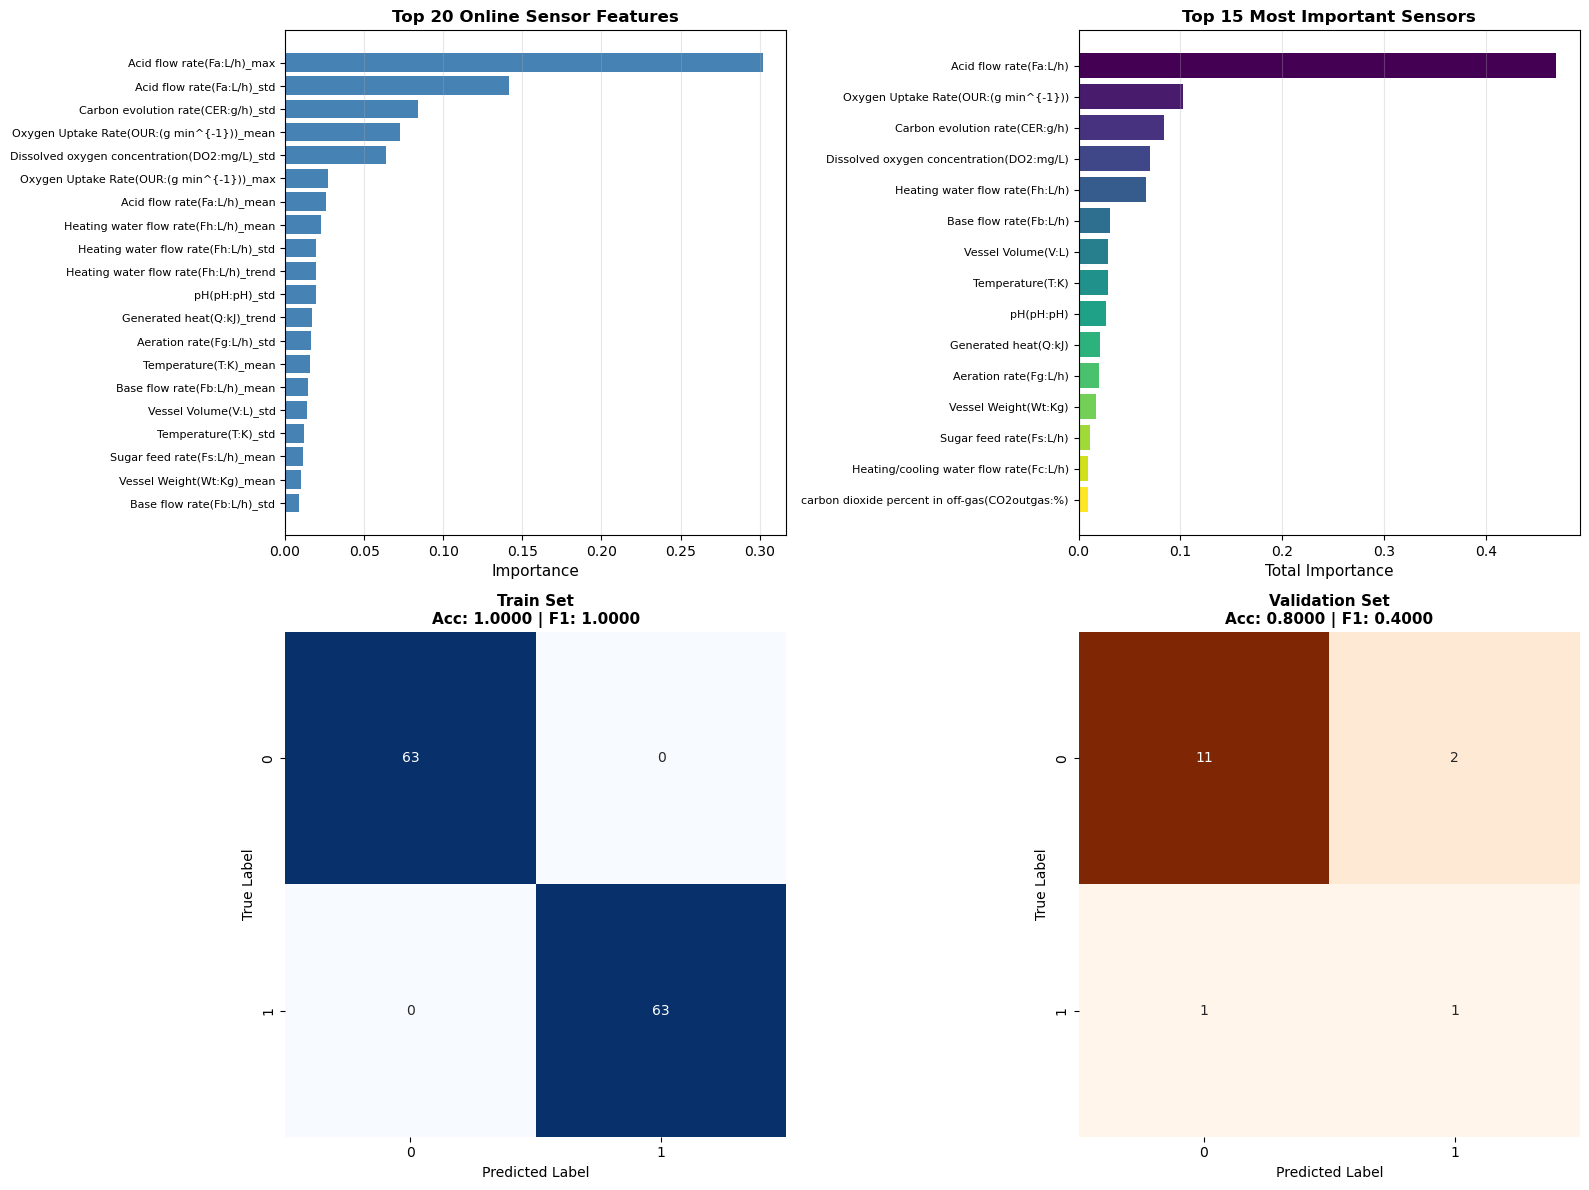

In [9]:

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
top_features = feature_importance_online.head(20)
ax.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values, fontsize=8)
ax.set_xlabel('Importance', fontsize=11)
ax.set_title('Top 20 Online Sensor Features', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

ax = axes[0, 1]
top_sensors = sensor_importance_df.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_sensors)))
ax.barh(range(len(top_sensors)), top_sensors['Total_Importance'].values, color=colors)
ax.set_yticks(range(len(top_sensors)))
ax.set_yticklabels(top_sensors['Sensor'].values, fontsize=8)
ax.set_xlabel('Total Importance', fontsize=11)
ax.set_title('Top 15 Most Important Sensors', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

ax = axes[1, 0]
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
ax.set_title(f'Train Set\nAcc: {train_acc:.4f} | F1: {train_f1:.4f}', 
             fontsize=11, fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

ax = axes[1, 1]
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Oranges', ax=ax, cbar=False)
ax.set_title(f'Validation Set\nAcc: {val_acc:.4f} | F1: {val_f1:.4f}', 
             fontsize=11, fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show() 
plt.close()

In the cell below we are checking how the model performs when progressuvely reducing the number of sensors based on importance.

In [10]:

feature_counts = [5, 10, 15, 20, 25, len(online_feature_cols)]
results = []

for n_features in feature_counts:
    
    top_n_features = feature_importance_online.head(n_features)['feature'].tolist()
    X_train_subset = X_train[top_n_features]
    X_val_subset = X_val[top_n_features]
    

    model_subset = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=9,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    model_subset.fit(
        X_train_subset, y_train,
        eval_set=[(X_val_subset, y_val)],
        verbose=False
    )
    
   
    val_pred = model_subset.predict(X_val_subset)
    val_acc_subset = accuracy_score(y_val, val_pred)
    val_f1_subset = f1_score(y_val, val_pred)
    
    results.append({
        'n_features': n_features,
        'val_accuracy': val_acc_subset,
        'val_f1': val_f1_subset
    })
    
    print(f"Top {n_features:3d} features: Val Acc={val_acc_subset:.4f}, F1={val_f1_subset:.4f}")

Top   5 features: Val Acc=0.9333, F1=0.6667
Top  10 features: Val Acc=0.8000, F1=0.4000
Top  15 features: Val Acc=0.8000, F1=0.4000
Top  20 features: Val Acc=0.8000, F1=0.4000
Top  25 features: Val Acc=0.8667, F1=0.5000
Top  95 features: Val Acc=0.8667, F1=0.5000


Actual test evaluation with held out data

In [11]:

y_test_pred = xgb_online.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
print(f"Test  - Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_test_pred, digits=4))

Test  - Accuracy: 0.8667, F1: 0.0000

Classification report:
              precision    recall  f1-score   support

           0     0.9286    0.9286    0.9286        14
           1     0.0000    0.0000    0.0000         1

    accuracy                         0.8667        15
   macro avg     0.4643    0.4643    0.4643        15
weighted avg     0.8667    0.8667    0.8667        15



# Cross-validation experiment for improvement of the results

The values below are the one that are actually considered in the thesis


In [12]:


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score


X_train_val_original = X_online.loc[X_temp.index]  
y_train_val_original = y[X_temp.index] 

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {
    'accuracy': [],
    'f1': [],
    'auc': [],
    'train_acc': []
}

cv_predictions = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val_original, y_train_val_original), 1):
    print(f"\nFold {fold}/5:", end=" ")
    
    X_fold_train = X_train_val_original.iloc[train_idx]
    X_fold_val = X_train_val_original.iloc[val_idx]
    y_fold_train = y_train_val_original[train_idx]  
    y_fold_val = y_train_val_original[val_idx]     
    
    
    train_fold_df = pd.concat([
        X_fold_train.reset_index(drop=True),
        pd.Series(y_fold_train, name='fault') 
    ], axis=1)
    
    maj_df_fold = train_fold_df[train_fold_df['fault'] == 0]
    min_df_fold = train_fold_df[train_fold_df['fault'] == 1]
    
    min_upsampled_fold = resample(
        min_df_fold,
        replace=True,
        n_samples=len(maj_df_fold),
        random_state=42
    )
    
    train_balanced_fold = pd.concat([maj_df_fold, min_upsampled_fold]).sample(frac=1, random_state=42)
    X_fold_train_balanced = train_balanced_fold.drop('fault', axis=1)
    y_fold_train_balanced = train_balanced_fold['fault'].values
    
   
    model_fold = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    model_fold.fit(X_fold_train_balanced, y_fold_train_balanced, verbose=False)
    
   
    y_fold_pred = model_fold.predict(X_fold_val)
    y_fold_pred_proba = model_fold.predict_proba(X_fold_val)[:, 1]
    

    fold_acc = accuracy_score(y_fold_val, y_fold_pred)
    fold_f1 = f1_score(y_fold_val, y_fold_pred, zero_division=0) 
    fold_auc = roc_auc_score(y_fold_val, y_fold_pred_proba)
    
    
    y_fold_train_pred = model_fold.predict(X_fold_train_balanced)
    fold_train_acc = accuracy_score(y_fold_train_balanced, y_fold_train_pred)
    
    cv_scores['accuracy'].append(fold_acc)
    cv_scores['f1'].append(fold_f1)
    cv_scores['auc'].append(fold_auc)
    cv_scores['train_acc'].append(fold_train_acc)
    
    print(f"Val Acc={fold_acc:.4f}, F1={fold_f1:.4f}, AUC={fold_auc:.4f}")

print("CROSS-VALIDATION SUMMARY")

print(f"\nMean ± Std across 5 folds:")
print(f"  Validation Accuracy: {np.mean(cv_scores['accuracy']):.4f} ± {np.std(cv_scores['accuracy']):.4f}")
print(f"  Validation F1-Score: {np.mean(cv_scores['f1']):.4f} ± {np.std(cv_scores['f1']):.4f}")
print(f"  Validation AUC:      {np.mean(cv_scores['auc']):.4f} ± {np.std(cv_scores['auc']):.4f}")
print(f"  Training Accuracy:   {np.mean(cv_scores['train_acc']):.4f} ± {np.std(cv_scores['train_acc']):.4f}")

print(f"\nSingle Test Set Results (for comparison):")
print(f"  Test Accuracy:  {test_acc:.4f}")
print(f"  Test F1-Score:  {test_f1:.4f}")



Fold 1/5: Val Acc=0.8824, F1=0.0000, AUC=0.9375

Fold 2/5: Val Acc=0.8824, F1=0.5000, AUC=0.9333

Fold 3/5: Val Acc=0.8824, F1=0.0000, AUC=0.9333

Fold 4/5: Val Acc=0.9412, F1=0.6667, AUC=0.7000

Fold 5/5: Val Acc=0.9412, F1=0.8000, AUC=1.0000
CROSS-VALIDATION SUMMARY

Mean ± Std across 5 folds:
  Validation Accuracy: 0.9059 ± 0.0288
  Validation F1-Score: 0.3933 ± 0.3349
  Validation AUC:      0.9008 ± 0.1036
  Training Accuracy:   1.0000 ± 0.0000

Single Test Set Results (for comparison):
  Test Accuracy:  0.8667
  Test F1-Score:  0.0000


 Figure 1A: Top 20 Individual Features


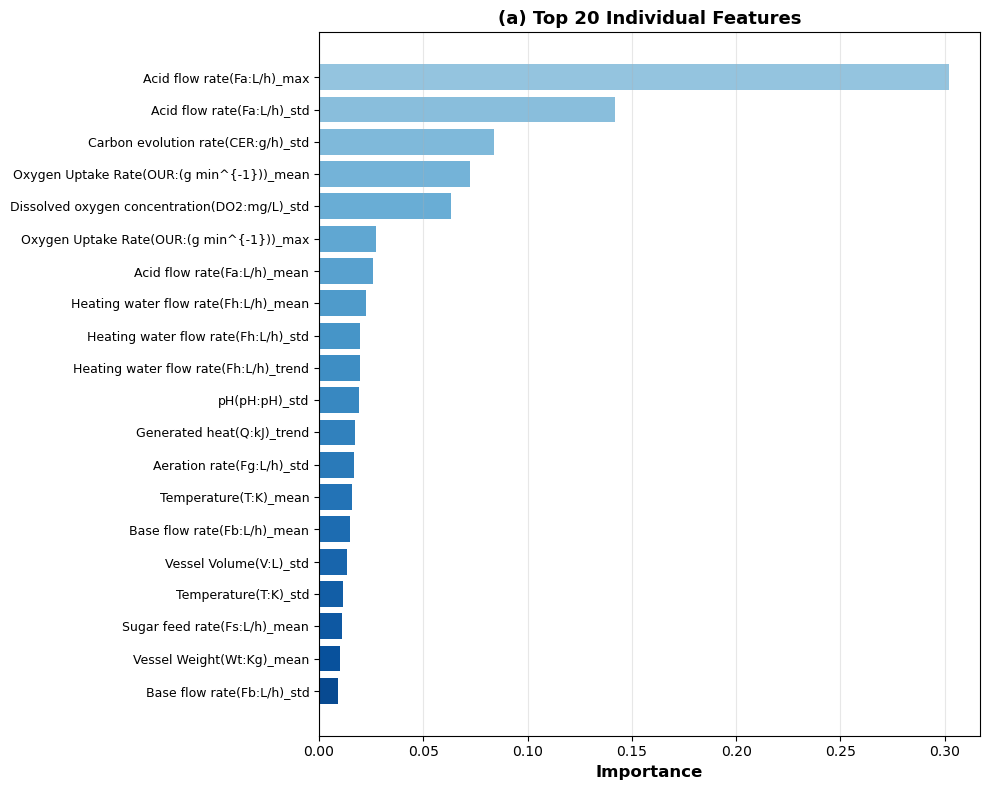


 Figure 1B: Top 15 Most Important Sensors


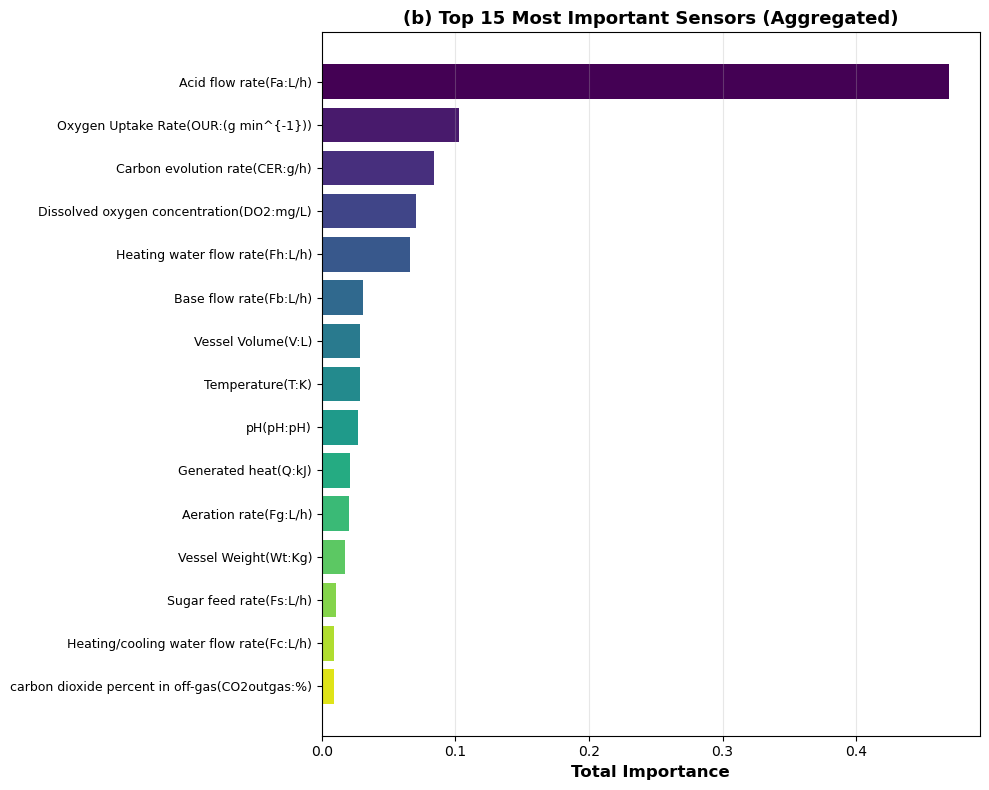


Figure 1C: Training Set Confusion Matrix


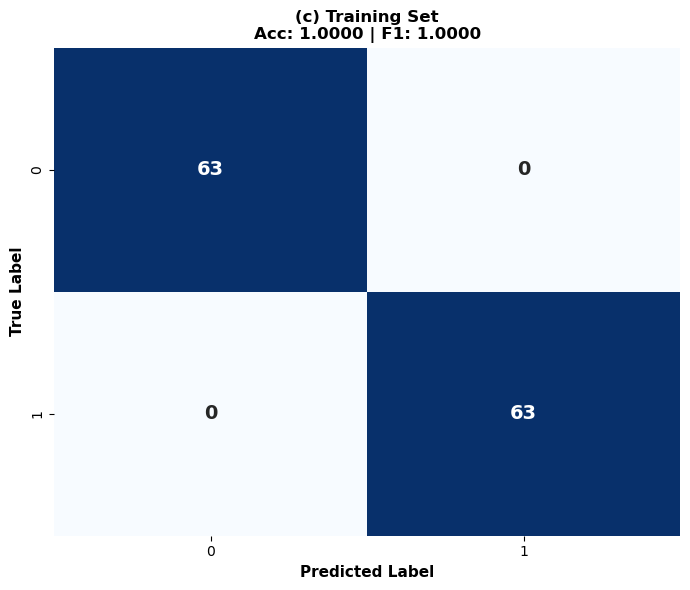


Figure 1D: Validation Set Confusion Matrix


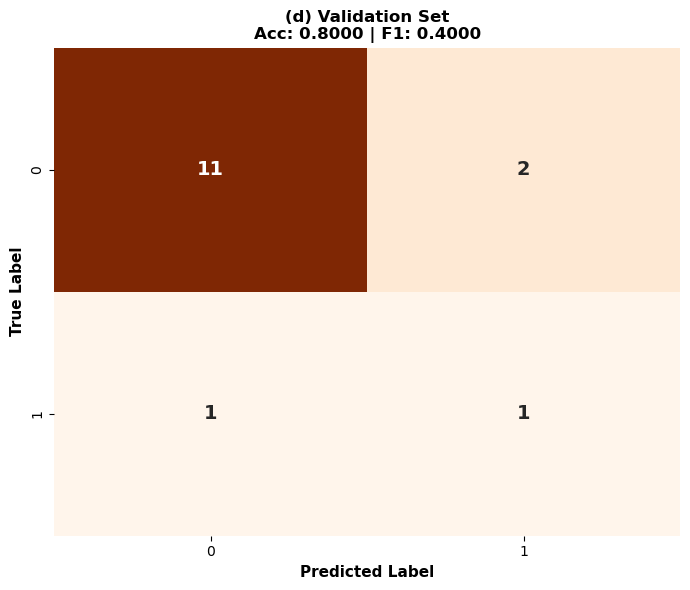


Figure 2A: Top 20 Most Important Sensors


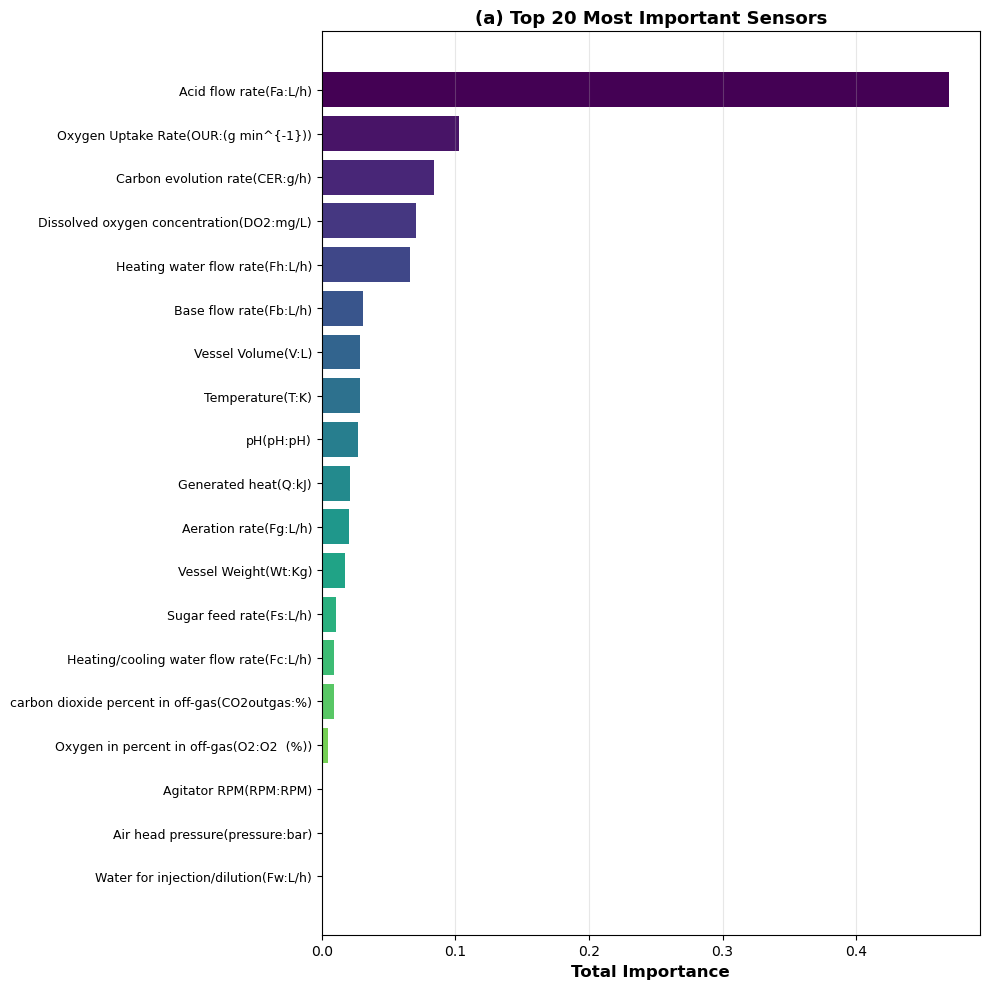


Figure 2B: ROC Curve - Test Set


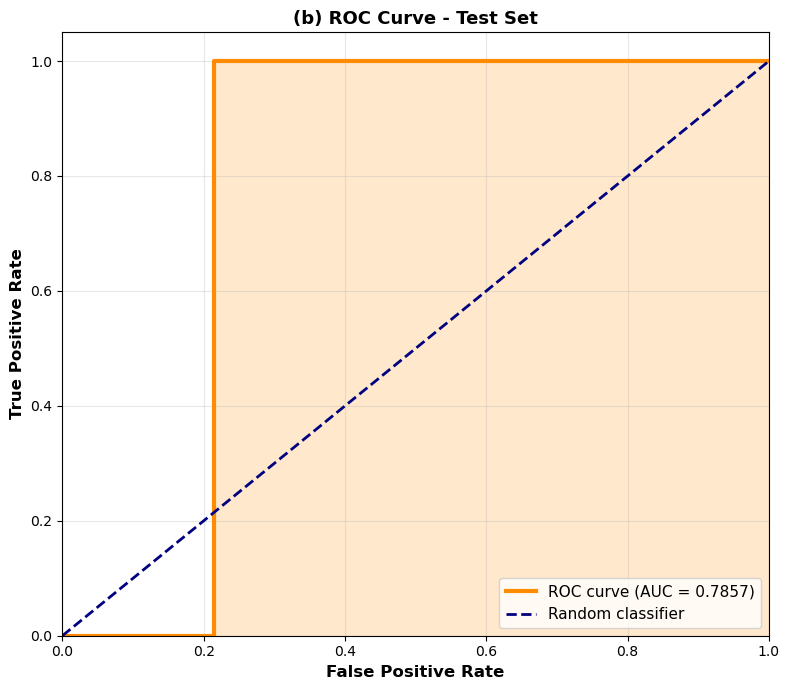


Figure 2C: Test Set Confusion Matrix


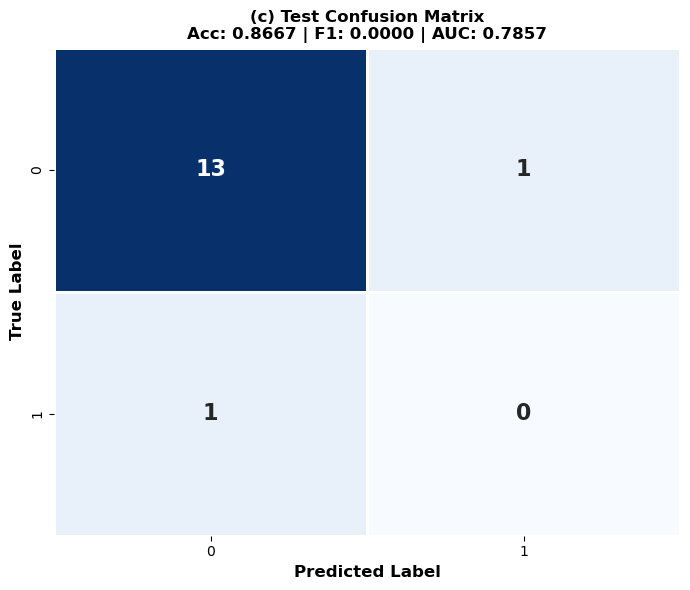

In [13]:


from sklearn.metrics import roc_curve, auc




print(" Figure 1A: Top 20 Individual Features")

fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance_online.head(20)
colors_features = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_features)))
ax.barh(range(len(top_features)), top_features['importance'].values, color=colors_features)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values, fontsize=9)
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('(a) Top 20 Individual Features', fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()


print("\n Figure 1B: Top 15 Most Important Sensors")

fig, ax = plt.subplots(figsize=(10, 8))
top_sensors = sensor_importance_df.head(15)
colors_sensors = plt.cm.viridis(np.linspace(0, 0.95, len(top_sensors)))
ax.barh(range(len(top_sensors)), top_sensors['Total_Importance'].values, color=colors_sensors)
ax.set_yticks(range(len(top_sensors)))
ax.set_yticklabels(top_sensors['Sensor'].values, fontsize=9)
ax.set_xlabel('Total Importance', fontsize=12, fontweight='bold')
ax.set_title('(b) Top 15 Most Important Sensors (Aggregated)', fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()


print("\nFigure 1C: Training Set Confusion Matrix")

fig, ax = plt.subplots(figsize=(7, 6))
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax, 
            cbar=False, annot_kws={'size': 14, 'weight': 'bold'})
ax.set_title(f'(c) Training Set\nAcc: {train_acc:.4f} | F1: {train_f1:.4f}', 
             fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()


print("\nFigure 1D: Validation Set Confusion Matrix")

fig, ax = plt.subplots(figsize=(7, 6))
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Oranges', ax=ax, 
            cbar=False, annot_kws={'size': 14, 'weight': 'bold'})
ax.set_title(f'(d) Validation Set\nAcc: {val_acc:.4f} | F1: {val_f1:.4f}', 
             fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()


print("\nFigure 2A: Top 20 Most Important Sensors")

fig, ax = plt.subplots(figsize=(10, 10))
top_sensors_20 = sensor_importance_df.head(20)
colors_sensors = plt.cm.viridis(np.linspace(0, 0.95, len(top_sensors_20)))
ax.barh(range(len(top_sensors_20)), top_sensors_20['Total_Importance'].values, color=colors_sensors)
ax.set_yticks(range(len(top_sensors_20)))
ax.set_yticklabels(top_sensors_20['Sensor'].values, fontsize=9)
ax.set_xlabel('Total Importance', fontsize=12, fontweight='bold')
ax.set_title('(a) Top 20 Most Important Sensors', fontsize=13, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()


print("\nFigure 2B: ROC Curve - Test Set")

fig, ax = plt.subplots(figsize=(8, 7))
y_test_proba = xgb_online.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
ax.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('(b) ROC Curve - Test Set', fontsize=13, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()


print("\nFigure 2C: Test Set Confusion Matrix")

fig, ax = plt.subplots(figsize=(7, 6))
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax, 
            cbar=False, annot_kws={'size': 16, 'weight': 'bold'},
            linewidths=2, linecolor='white')
ax.set_title(f'(c) Test Confusion Matrix\nAcc: {test_acc:.4f} | F1: {test_f1:.4f} | AUC: {roc_auc:.4f}', 
             fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()

In [14]:
# %% Calculate Sensor Importance Across CV Folds
print("\n" + "="*60)
print("CALCULATING SENSOR IMPORTANCE PER FOLD")
print("="*60)

# Initialize dictionary to store sensor importance per fold
sensor_importance_per_fold = {}

# Train models for each fold and extract sensor importance
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val_original, y_train_val_original), 1):
    print(f"\nFold {fold}/5: Extracting sensor importance...", end=" ")
    
    X_fold_train = X_train_val_original.iloc[train_idx]
    y_fold_train = y_train_val_original[train_idx]
    
    # Balance training fold
    train_fold_df = pd.concat([
        X_fold_train.reset_index(drop=True),
        pd.Series(y_fold_train, name='fault')
    ], axis=1)
    
    maj_df_fold = train_fold_df[train_fold_df['fault'] == 0]
    min_df_fold = train_fold_df[train_fold_df['fault'] == 1]
    min_upsampled_fold = resample(min_df_fold, replace=True, 
                                   n_samples=len(maj_df_fold), random_state=42)
    train_balanced_fold = pd.concat([maj_df_fold, min_upsampled_fold]).sample(frac=1, random_state=42)
    X_fold_train_balanced = train_balanced_fold.drop('fault', axis=1)
    y_fold_train_balanced = train_balanced_fold['fault'].values
    
    # Train model
    model_fold = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    model_fold.fit(X_fold_train_balanced, y_fold_train_balanced, verbose=False)
    
    # Get feature importances
    feature_importances_fold = pd.DataFrame({
        'feature': X_fold_train_balanced.columns,
        'importance': model_fold.feature_importances_
    })
    
    # Aggregate by sensor
    sensor_importance_fold = {}
    for idx, row in feature_importances_fold.iterrows():
        feature_name = row['feature']
        for sensor in online_sensors:
            if feature_name.startswith(sensor):
                if sensor not in sensor_importance_fold:
                    sensor_importance_fold[sensor] = 0
                sensor_importance_fold[sensor] += row['importance']
                break
    
    # Store in dictionary
    sensor_importance_per_fold[f'Fold{fold}_Importance'] = sensor_importance_fold
    print("Done")

# Create DataFrame with all folds
sensor_importance_cv = pd.DataFrame(sensor_importance_per_fold)
sensor_importance_cv['Sensor'] = sensor_importance_cv.index
sensor_importance_cv = sensor_importance_cv.reset_index(drop=True)

# Calculate mean and std across folds
sensor_importance_cv['Mean_Importance'] = sensor_importance_cv[
    [f'Fold{i}_Importance' for i in range(1, 6)]
].mean(axis=1)

sensor_importance_cv['Std_Importance'] = sensor_importance_cv[
    [f'Fold{i}_Importance' for i in range(1, 6)]
].std(axis=1)

# Sort by mean importance
sensor_importance_cv = sensor_importance_cv.sort_values('Mean_Importance', ascending=False)

print("\n" + "="*60)
print("TOP 10 SENSORS (CV Average)")
print("="*60)
print(sensor_importance_cv[['Sensor', 'Mean_Importance', 'Std_Importance']].head(10).to_string(index=False))


CALCULATING SENSOR IMPORTANCE PER FOLD

Fold 1/5: Extracting sensor importance... Done

Fold 2/5: Extracting sensor importance... Done

Fold 3/5: Extracting sensor importance... Done

Fold 4/5: Extracting sensor importance... Done

Fold 5/5: Extracting sensor importance... Done

TOP 10 SENSORS (CV Average)
                                  Sensor  Mean_Importance  Std_Importance
                        Temperature(T:K)         0.166151        0.101480
                  Acid flow rate(Fa:L/h)         0.166028        0.081594
Dissolved oxygen concentration(DO2:mg/L)         0.143843        0.098343
                               pH(pH:pH)         0.118604        0.052731
                      Vessel Volume(V:L)         0.064883        0.048563
    Oxygen Uptake Rate(OUR:(g min^{-1}))         0.040814        0.040713
 Heating/cooling water flow rate(Fc:L/h)         0.039069        0.038450
                 Sugar feed rate(Fs:L/h)         0.038787        0.042743
                    Gener

Figure CV1: Sensor Importance Per Fold + Mean


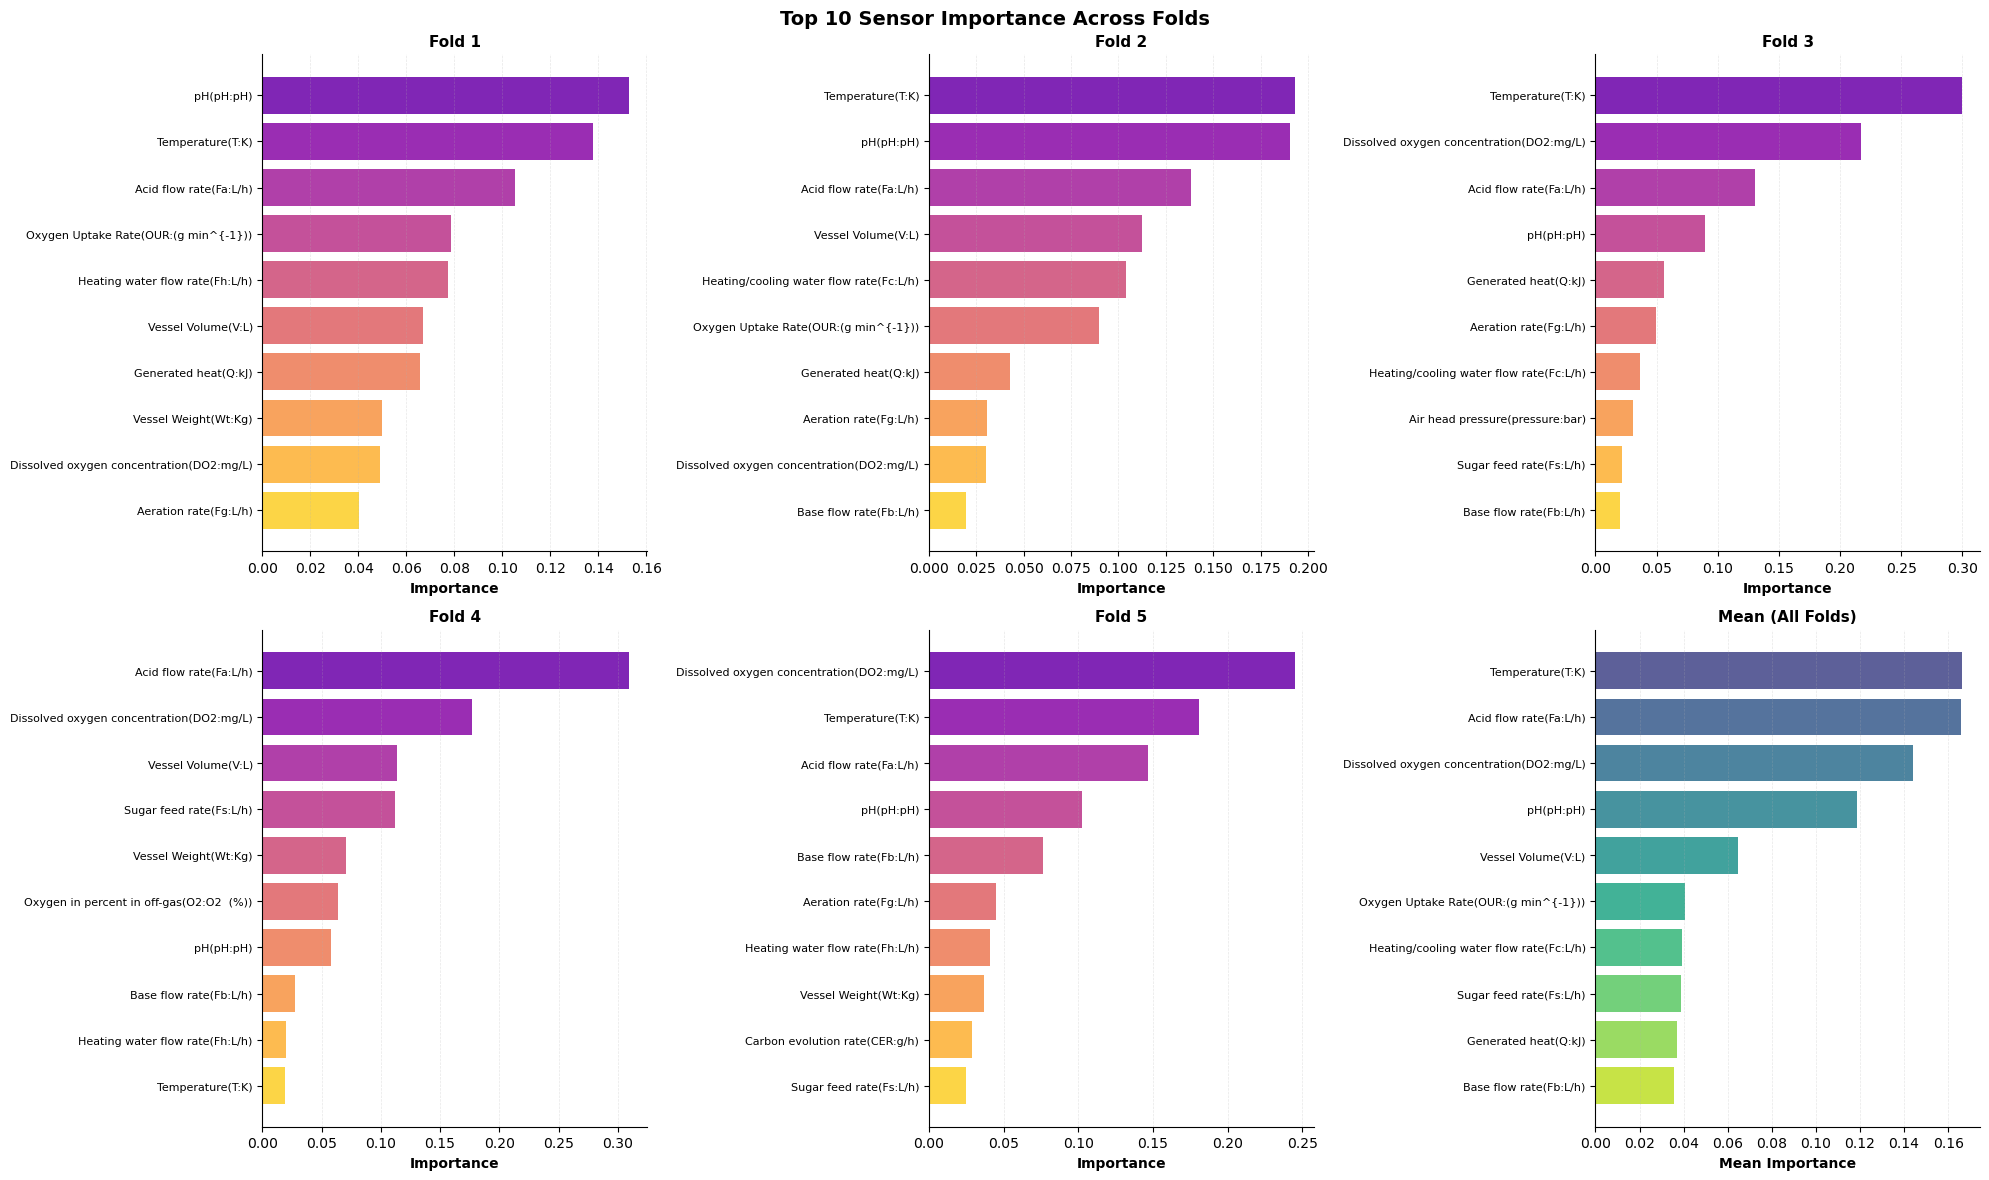

Figure CV2: Original Model vs CV Average Comparison


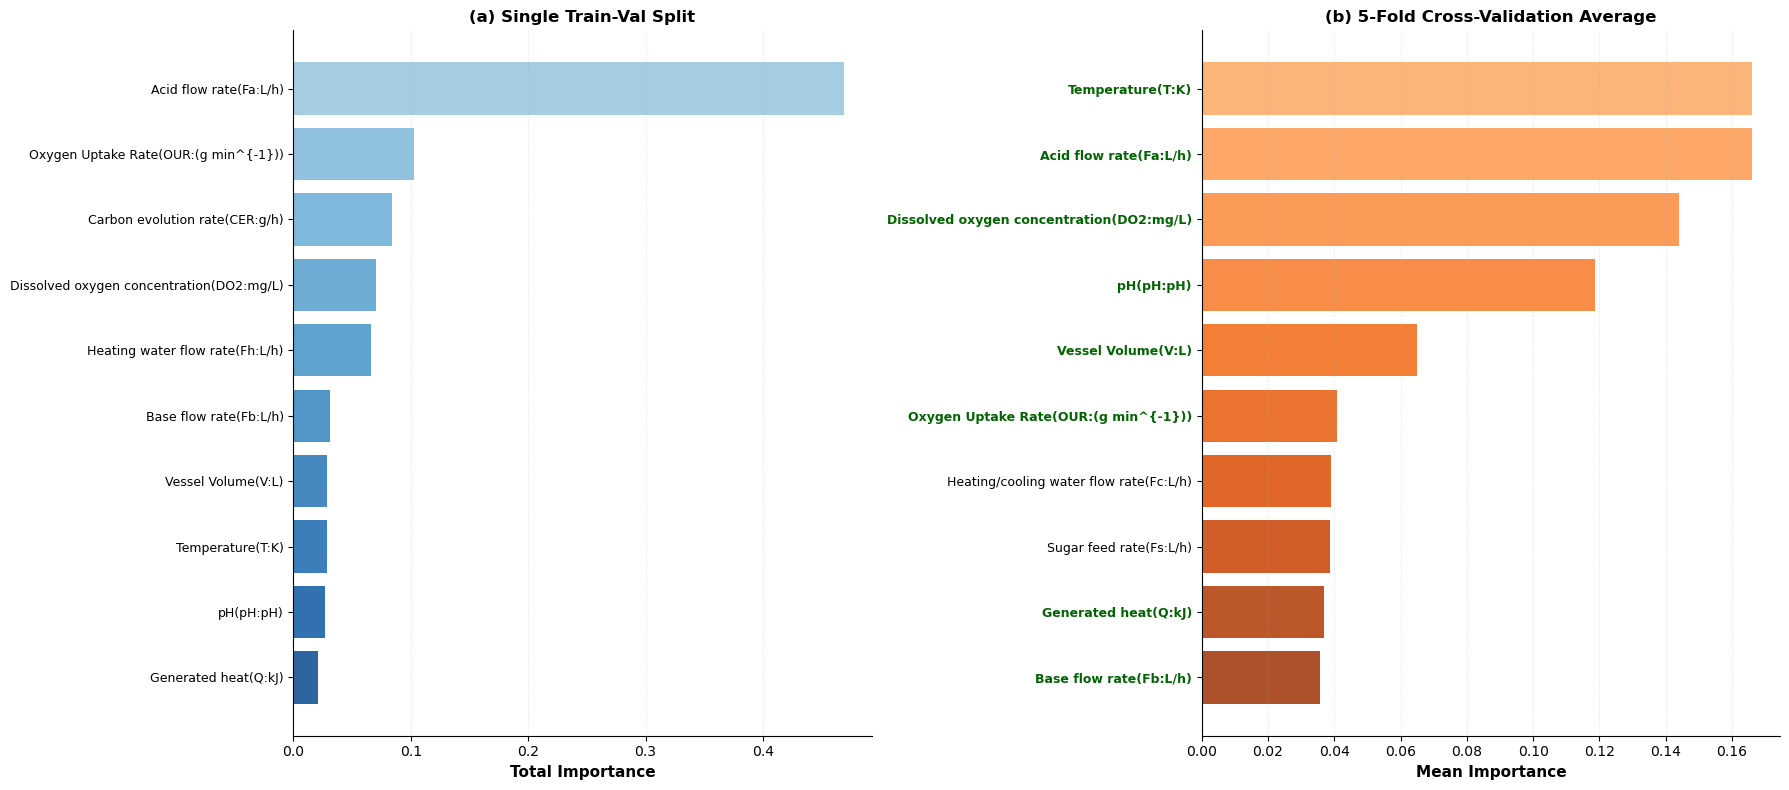

Figure CV3: Cross-Validation Performance Per Fold


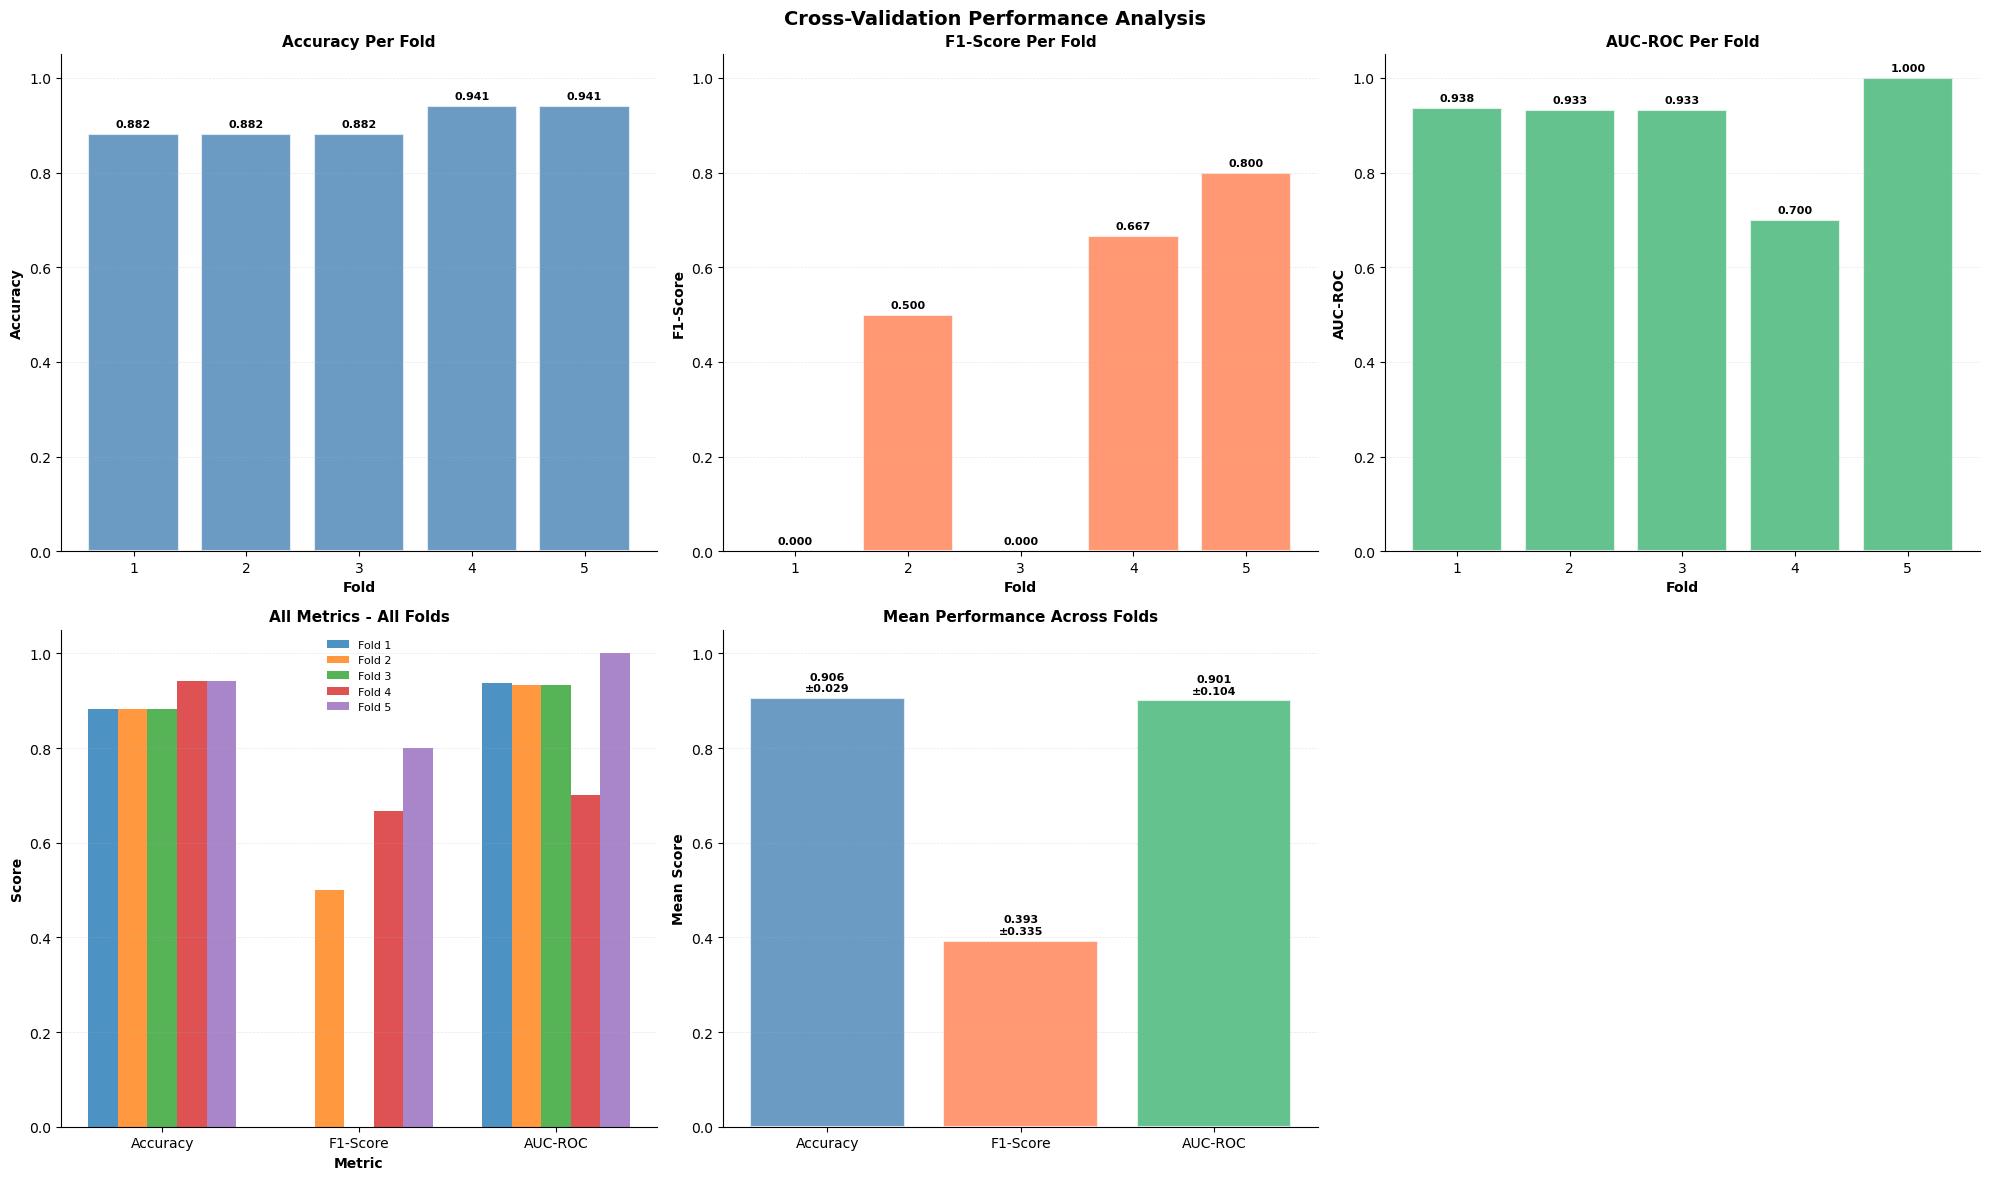

Figure CV4: ROC Curves Per Fold + Mean


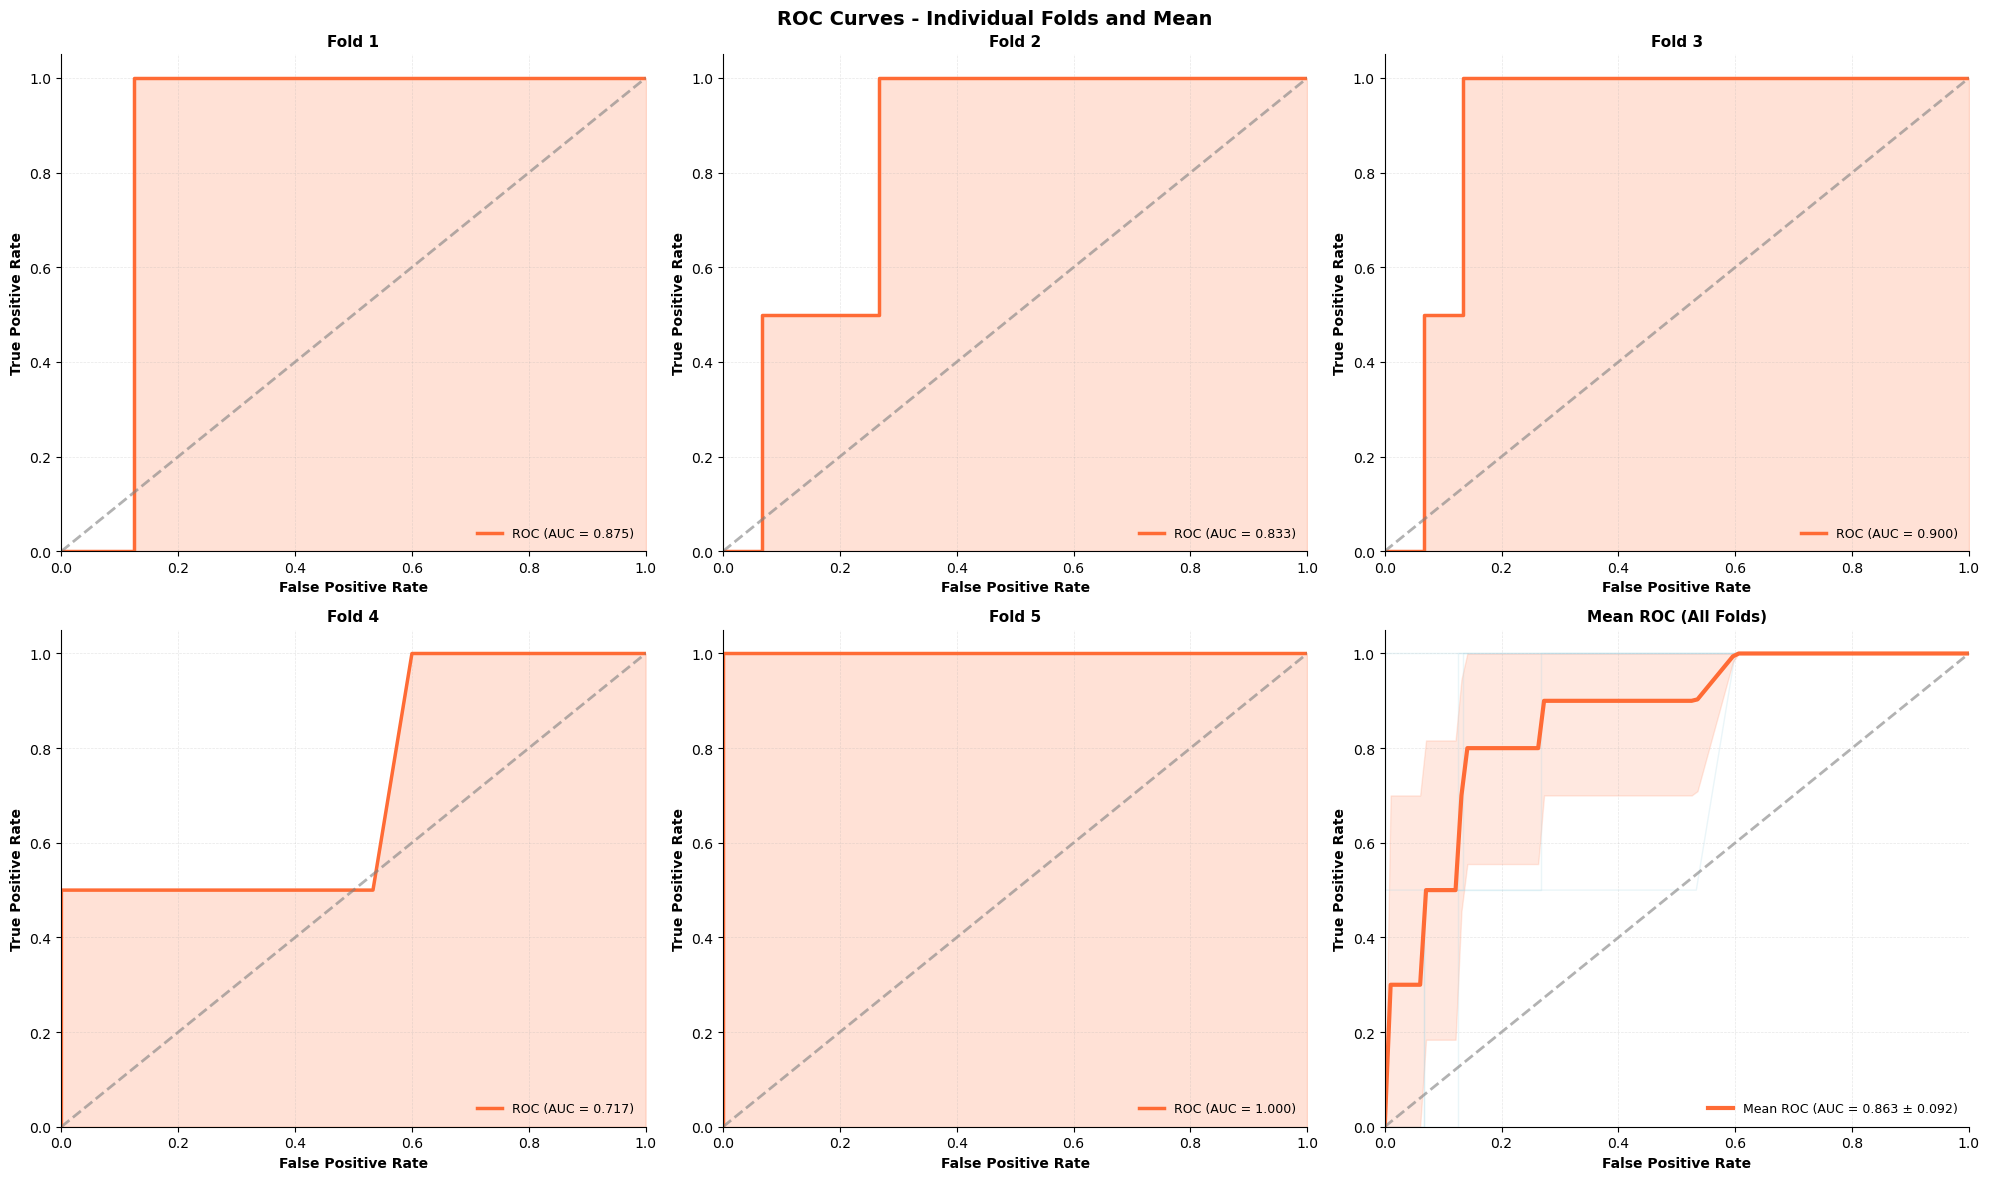

In [15]:

print("Figure CV1: Sensor Importance Per Fold + Mean")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()


for fold_idx in range(5):
    ax = axes[fold_idx]
    fold_col = f'Fold{fold_idx + 1}_Importance'
    
    
    fold_data = sensor_importance_cv.nlargest(10, fold_col)
    
    colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(fold_data)))
    ax.barh(range(len(fold_data)), fold_data[fold_col].values, color=colors, alpha=0.85)
    ax.set_yticks(range(len(fold_data)))
    ax.set_yticklabels(fold_data['Sensor'].values, fontsize=8)
    ax.set_xlabel('Importance', fontsize=10, fontweight='bold')
    ax.set_title(f'Fold {fold_idx + 1}', fontsize=11, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax = axes[5]
top_sensors_mean = sensor_importance_cv.head(10)
colors_mean = plt.cm.viridis(np.linspace(0.2, 0.9, len(top_sensors_mean)))
ax.barh(range(len(top_sensors_mean)), top_sensors_mean['Mean_Importance'].values, 
        color=colors_mean, alpha=0.85)
ax.set_yticks(range(len(top_sensors_mean)))
ax.set_yticklabels(top_sensors_mean['Sensor'].values, fontsize=8)
ax.set_xlabel('Mean Importance', fontsize=10, fontweight='bold')
ax.set_title('Mean (All Folds)', fontsize=11, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.suptitle('Top 10 Sensor Importance Across Folds', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()


print("Figure CV2: Original Model vs CV Average Comparison")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))


top_10_orig = sensor_importance_df.head(10)
colors_orig = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_10_orig)))
ax1.barh(range(len(top_10_orig)), top_10_orig['Total_Importance'].values, 
         color=colors_orig, alpha=0.85, edgecolor='none')
ax1.set_yticks(range(len(top_10_orig)))
ax1.set_yticklabels(top_10_orig['Sensor'].values, fontsize=9)
ax1.set_xlabel('Total Importance', fontsize=11, fontweight='bold')
ax1.set_title('(a) Single Train-Val Split', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


top_10_cv_plot = sensor_importance_cv.head(10)
colors_cv = plt.cm.Oranges(np.linspace(0.4, 0.9, len(top_10_cv_plot)))
ax2.barh(range(len(top_10_cv_plot)), 
         top_10_cv_plot['Mean_Importance'].values,
         color=colors_cv, alpha=0.85, edgecolor='none')
ax2.set_yticks(range(len(top_10_cv_plot)))
ax2.set_yticklabels(top_10_cv_plot['Sensor'].values, fontsize=9)
ax2.set_xlabel('Mean Importance', fontsize=11, fontweight='bold')
ax2.set_title('(b) 5-Fold Cross-Validation Average', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

top_10_original_list = top_10_orig['Sensor'].values
for i, sensor in enumerate(top_10_cv_plot['Sensor'].values):
    if sensor in top_10_original_list:
        ax2.get_yticklabels()[i].set_weight('bold')
        ax2.get_yticklabels()[i].set_color('darkgreen')

plt.tight_layout()
plt.show()
plt.close()


print("Figure CV3: Cross-Validation Performance Per Fold")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

folds = np.arange(1, 6)
metrics = {
    'Accuracy': cv_scores['accuracy'],
    'F1-Score': cv_scores['f1'],
    'AUC-ROC': cv_scores['auc']
}
colors_metrics = ['#4682B4', '#FF7F50', '#3CB371']
metric_names = list(metrics.keys())


for idx, (metric_name, values) in enumerate(metrics.items()):
    ax = axes[idx]
    
    bars = ax.bar(folds, values, color=colors_metrics[idx], alpha=0.8, 
                   edgecolor='white', linewidth=1.5)
    
    ax.set_xlabel('Fold', fontsize=10, fontweight='bold')
    ax.set_ylabel(metric_name, fontsize=10, fontweight='bold')
    ax.set_title(f'{metric_name} Per Fold', fontsize=11, fontweight='bold')
    ax.set_xticks(folds)
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    

    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')


ax = axes[3]
x = np.arange(len(metric_names))
width = 0.15

for fold_idx in range(5):
    fold_values = [cv_scores['accuracy'][fold_idx], 
                   cv_scores['f1'][fold_idx], 
                   cv_scores['auc'][fold_idx]]
    ax.bar(x + fold_idx * width, fold_values, width, 
           label=f'Fold {fold_idx + 1}', alpha=0.8)

ax.set_xlabel('Metric', fontsize=10, fontweight='bold')
ax.set_ylabel('Score', fontsize=10, fontweight='bold')
ax.set_title('All Metrics - All Folds', fontsize=11, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(metric_names)
ax.set_ylim(0, 1.05)
ax.legend(fontsize=8, frameon=False)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax = axes[4]
mean_values = [np.mean(cv_scores['accuracy']), 
               np.mean(cv_scores['f1']), 
               np.mean(cv_scores['auc'])]
std_values = [np.std(cv_scores['accuracy']), 
              np.std(cv_scores['f1']), 
              np.std(cv_scores['auc'])]

bars = ax.bar(metric_names, mean_values, color=colors_metrics, alpha=0.8,
              edgecolor='white', linewidth=1.5)

ax.set_ylabel('Mean Score', fontsize=10, fontweight='bold')
ax.set_title('Mean Performance Across Folds', fontsize=11, fontweight='bold')
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


for bar, val, std in zip(bars, mean_values, std_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{val:.3f}\n±{std:.3f}', ha='center', va='bottom', 
            fontsize=8, fontweight='bold')

axes[5].axis('off')

plt.suptitle('Cross-Validation Performance Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()


print("Figure CV4: ROC Curves Per Fold + Mean")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

mean_fpr = np.linspace(0, 1, 100)
tprs = []
fold_models = []


for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val_original, y_train_val_original), 1):
    ax = axes[fold - 1]
    
    X_fold_train = X_train_val_original.iloc[train_idx]
    X_fold_val = X_train_val_original.iloc[val_idx]
    y_fold_train = y_train_val_original[train_idx]
    y_fold_val = y_train_val_original[val_idx]
    
    
    train_fold_df = pd.concat([
        X_fold_train.reset_index(drop=True),
        pd.Series(y_fold_train, name='fault')
    ], axis=1)
    
    maj_df_fold = train_fold_df[train_fold_df['fault'] == 0]
    min_df_fold = train_fold_df[train_fold_df['fault'] == 1]
    min_upsampled_fold = resample(min_df_fold, replace=True, 
                                   n_samples=len(maj_df_fold), random_state=42)
    train_balanced_fold = pd.concat([maj_df_fold, min_upsampled_fold]).sample(frac=1, random_state=42)
    X_fold_train_balanced = train_balanced_fold.drop('fault', axis=1)
    y_fold_train_balanced = train_balanced_fold['fault'].values
    
    
    model_fold = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200,
                                    max_depth=6, learning_rate=0.1, random_state=42,
                                    n_jobs=-1, eval_metric='logloss')
    model_fold.fit(X_fold_train_balanced, y_fold_train_balanced, verbose=False)
    

    y_fold_proba = model_fold.predict_proba(X_fold_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_fold_val, y_fold_proba)
    fold_auc = auc(fpr, tpr)
    
    
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    

    ax.plot(fpr, tpr, color='#FF6B35', lw=2.5, label=f'ROC (AUC = {fold_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.6)
    ax.fill_between(fpr, tpr, alpha=0.2, color='#FF6B35')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=10, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=10, fontweight='bold')
    ax.set_title(f'Fold {fold}', fontsize=11, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9, frameon=False)
    ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


ax = axes[5]


for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val_original, y_train_val_original), 1):
    X_fold_train = X_train_val_original.iloc[train_idx]
    X_fold_val = X_train_val_original.iloc[val_idx]
    y_fold_train = y_train_val_original[train_idx]
    y_fold_val = y_train_val_original[val_idx]
    
    train_fold_df = pd.concat([
        X_fold_train.reset_index(drop=True),
        pd.Series(y_fold_train, name='fault')
    ], axis=1)
    
    maj_df_fold = train_fold_df[train_fold_df['fault'] == 0]
    min_df_fold = train_fold_df[train_fold_df['fault'] == 1]
    min_upsampled_fold = resample(min_df_fold, replace=True, 
                                   n_samples=len(maj_df_fold), random_state=42)
    train_balanced_fold = pd.concat([maj_df_fold, min_upsampled_fold]).sample(frac=1, random_state=42)
    X_fold_train_balanced = train_balanced_fold.drop('fault', axis=1)
    y_fold_train_balanced = train_balanced_fold['fault'].values
    
    model_fold = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200,
                                    max_depth=6, learning_rate=0.1, random_state=42,
                                    n_jobs=-1, eval_metric='logloss')
    model_fold.fit(X_fold_train_balanced, y_fold_train_balanced, verbose=False)
    
    y_fold_proba = model_fold.predict_proba(X_fold_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_fold_val, y_fold_proba)
    
    ax.plot(fpr, tpr, alpha=0.25, linewidth=1, color='lightblue')


mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std([auc(mean_fpr, tpr) for tpr in tprs])

ax.plot(mean_fpr, mean_tpr, color='#FF6B35', linewidth=3,
        label=f'Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})')


std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='#FF6B35', alpha=0.15)

ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.6)

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=10, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=10, fontweight='bold')
ax.set_title('Mean ROC (All Folds)', fontsize=11, fontweight='bold')
ax.legend(loc='lower right', fontsize=9, frameon=False)
ax.grid(alpha=0.3, linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.suptitle('ROC Curves - Individual Folds and Mean', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close()


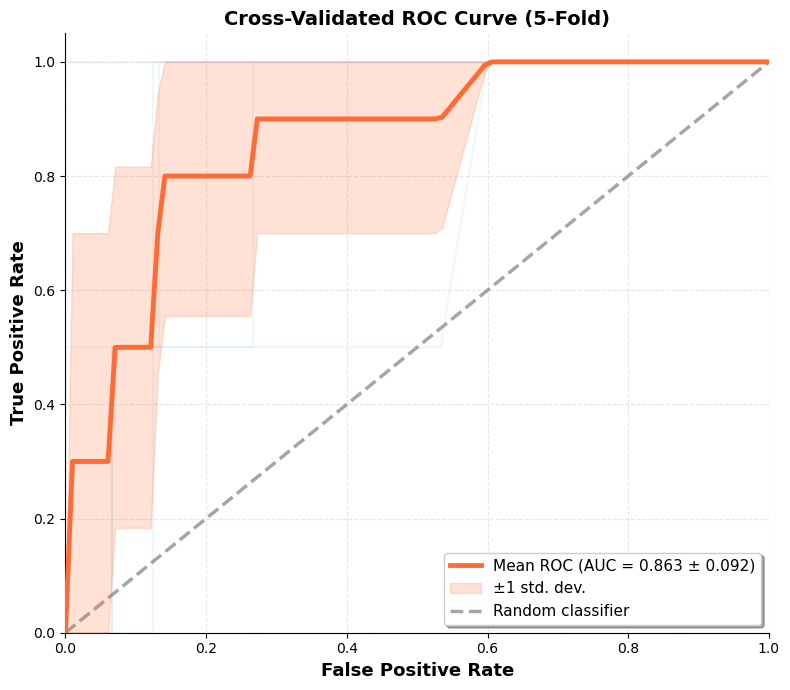

In [16]:
fig, ax = plt.subplots(figsize=(8, 7))


for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val_original, y_train_val_original), 1):
    X_fold_train = X_train_val_original.iloc[train_idx]
    X_fold_val = X_train_val_original.iloc[val_idx]
    y_fold_train = y_train_val_original[train_idx]
    y_fold_val = y_train_val_original[val_idx]
    
   
    train_fold_df = pd.concat([
        X_fold_train.reset_index(drop=True),
        pd.Series(y_fold_train, name='fault')
    ], axis=1)
    
    maj_df_fold = train_fold_df[train_fold_df['fault'] == 0]
    min_df_fold = train_fold_df[train_fold_df['fault'] == 1]
    min_upsampled_fold = resample(min_df_fold, replace=True, 
                                   n_samples=len(maj_df_fold), random_state=42)
    train_balanced_fold = pd.concat([maj_df_fold, min_upsampled_fold]).sample(frac=1, random_state=42)
    X_fold_train_balanced = train_balanced_fold.drop('fault', axis=1)
    y_fold_train_balanced = train_balanced_fold['fault'].values
    
 
    model_fold = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200,
                                    max_depth=6, learning_rate=0.1, random_state=42,
                                    n_jobs=-1, eval_metric='logloss')
    model_fold.fit(X_fold_train_balanced, y_fold_train_balanced, verbose=False)
    
  
    y_fold_proba = model_fold.predict_proba(X_fold_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_fold_val, y_fold_proba)
    ax.plot(fpr, tpr, alpha=0.2, linewidth=1.5, color='lightblue')


ax.plot(mean_fpr, mean_tpr, color='#FF6B35', linewidth=3.5,
        label=f'Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})', zorder=10)


ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='#FF6B35', 
                alpha=0.2, label='±1 std. dev.', zorder=5)

ax.plot([0, 1], [0, 1], color='gray', lw=2.5, linestyle='--', 
        alpha=0.7, label='Random classifier')


ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('Cross-Validated ROC Curve (5-Fold)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11, frameon=True, shadow=True)
ax.grid(alpha=0.3, linestyle='--', linewidth=0.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
plt.close()
